### In this notebook we want to encode the summaries we created before and use those encodings for semantic search

In [3]:
import pickle
from sentence_transformers import SentenceTransformer




In [4]:
with open("data/punctuation_correction/summaries/sumy_summaries_cleaned.pkl", "rb") as file:
  summaries = pickle.load(file)

In [5]:
from transformers import BertTokenizer 
#we assume the tokenizer of different Bert models is similar or the same
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')


In [1]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download("punkt")


[nltk_data] Downloading package punkt to /home/Andreas.B/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
import nltk

from sumy.nlp.tokenizers import Tokenizer as SumyTokenizer
 

def sentence_separator(text, tokenizer):
    sentences = tokenizer.to_sentences(text)
    return sentences

In [7]:
sumy_tokenizer = SumyTokenizer("de")
sentence_counter = 0
sentences_to_summary_dict = {}
sentences = []
for index,summary in enumerate(summaries):
    if index % 10000 == 0:
        print(index)
    tmp_sentences = sentence_separator(summary, sumy_tokenizer)
    for si in range(len(tmp_sentences)):
        sentences_to_summary_dict[sentence_counter + si] = index
    sentence_counter += len(tmp_sentences)
    sentences += tmp_sentences


0
10000
20000
30000
40000
50000
60000
70000


In [8]:
len(sentences)

694633

In [11]:
def count_tokens(tokenizer, texts):
    token_lengths = []
    tokens = tokenizer.batch_encode_plus(texts, padding=False, truncation=False)
    for input_ids in tokens["input_ids"]:
        token_lengths.append(len(input_ids))
    return token_lengths




### Lets check, how long (number of tokens) the sentences are.

In [12]:
batch_size = 100000  # Number of texts to tokenize in each batch
token_lengths = []
for i in range(0, len(sentences), batch_size):
    batch_texts = sentences[i:i+batch_size]
    token_lengths.extend(count_tokens(tokenizer, batch_texts))
    print(f"Processed {i + len(batch_texts)} texts")

print(token_lengths)

Token indices sequence length is longer than the specified maximum sequence length for this model (1325 > 512). Running this sequence through the model will result in indexing errors


Processed 100000 texts
Processed 200000 texts
Processed 300000 texts
Processed 400000 texts
Processed 500000 texts
Processed 600000 texts
Processed 694633 texts
[18, 88, 97, 132, 18, 96, 122, 43, 77, 83, 69, 105, 54, 114, 27, 41, 21, 57, 57, 55, 27, 36, 32, 21, 45, 22, 77, 74, 123, 30, 76, 267, 11, 23, 47, 12, 21, 43, 59, 83, 65, 94, 59, 47, 57, 87, 113, 86, 30, 35, 81, 44, 90, 67, 50, 77, 17, 88, 48, 81, 94, 36, 93, 50, 107, 56, 23, 13, 55, 19, 55, 77, 199, 73, 87, 27, 88, 92, 86, 121, 32, 67, 105, 31, 91, 47, 88, 148, 83, 61, 49, 31, 70, 114, 154, 87, 18, 71, 75, 47, 54, 38, 25, 7, 10, 26, 13, 25, 60, 26, 51, 54, 76, 47, 64, 95, 40, 8, 45, 31, 145, 135, 30, 53, 84, 47, 8, 85, 169, 22, 103, 43, 52, 39, 74, 127, 76, 71, 28, 45, 43, 66, 33, 32, 37, 65, 71, 46, 137, 74, 94, 115, 78, 33, 11, 114, 115, 59, 107, 57, 95, 99, 104, 28, 73, 102, 67, 59, 57, 9, 34, 31, 93, 62, 49, 154, 28, 101, 121, 177, 52, 67, 44, 18, 15, 75, 110, 17, 155, 9, 75, 128, 35, 63, 32, 38, 29, 69, 151, 76, 59, 99, 1

{'whiskers': [<matplotlib.lines.Line2D at 0x7fa37ab03700>,
 'caps': [<matplotlib.lines.Line2D at 0x7fa37ab02470>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fa37ab03010>],
 'medians': [<matplotlib.lines.Line2D at 0x7fa37ab02da0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fa37ab02a70>],
 'means': []}

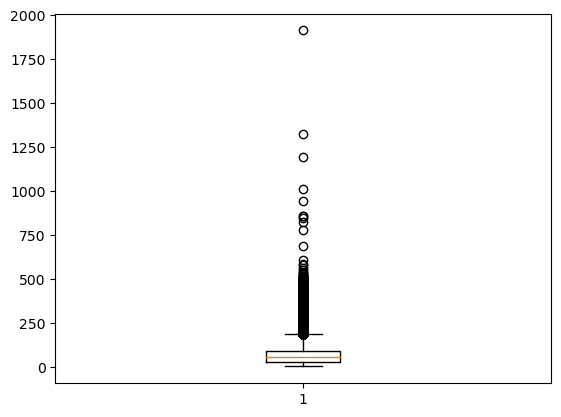

In [13]:
import matplotlib.pyplot as plt

plt.boxplot(token_lengths)

In [18]:
#check, how many sentences are longer than 512. 
longer_than = sum([x > 512 for x in token_lengths])
print(longer_than)


25


Only 25 of our nearly 700000 sentences are longer than 512 tokens. So we can use a standard BERT encoder. 

In [22]:
from sentence_transformers import SentenceTransformer, util

# Load a pre-trained Sentence Transformer model
model = SentenceTransformer('bert-base-german-cased')


No sentence-transformers model found with name /home/Andreas.B/.cache/torch/sentence_transformers/bert-base-german-cased. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /home/Andreas.B/.cache/torch/sentence_transformers/bert-base-german-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequ

### Calculate the embeddings. 
- Caution: this will need a lot of time. We already computed the encodings. If you do not want to change anything about the calculations, simply skip to the next chapter, where the encodings are loaded. 
- the lines were commented out, so they are not exectued by accident.

In [23]:
# import numpy as np
# import torch
# # Set the batch size for encoding
# batch_size = 4096
# # Determine the number of batches needed
# num_batches = int(np.ceil(len(sentences) / batch_size))

# # Initialize an empty list to store the final embeddings
# all_embeddings = []
# #with toch.no_grad() means, that no gradients are stored. Since we do not train, we do not need them and this lowers the VRAM needed. 
# with torch.no_grad():
#   # Encode sentences in batches
#   for i in range(num_batches):
#       print(i+1, "/", num_batches)
#       # Calculate the start and end indices for the current batch
#       start_idx = i * batch_size
#       end_idx = min((i + 1) * batch_size, len(sentences))

#       # Extract the current batch of sentences
#       batch_sentences = sentences[start_idx:end_idx]

#       # Encode the current batch of sentences
#       batch_embeddings = model.encode(batch_sentences)
#       # Append the batch embeddings to the final list
#       save_path = f"data/punctuation_correction/summaries/encodings/by_tokenizer/summary_sentence_encodings_{i + 1}.pickle"
#       with open(save_path, "wb") as f:
#             pickle.dump(batch_embeddings, f)


In [24]:
# #load the encoded batches from the disk and concat them
# directory_path = f"data/punctuation_correction/summaries/encodings"
# encodings = []

# for root, dirs, files in os.walk(directory_path):
#     for filename in files:
#         if "summary_sentence_encodings" in filename:
#             file_path = os.path.join(root, filename)
#             with open(file_path, "rb") as file_obj:
#                 encodings.append(pickle.load(file_obj))


# import numpy as np
# encodings_array = np.concatenate(encodings, axis=0)


In [ ]:
# with open(directory_path + "result.pkl", "wb+") as file_obj:
#     pickle.dump(encodings_array, file_obj)

### Experiment with encodings 
- Now we want to use the encodings by calculating the cos similarity between them and the encodings for search queries. 

In [ ]:
# Load encodings from the disk
directory_path = f"data/punctuation_correction/summaries/encodings/"
with open(directory_path + "result.pkl", "rb") as file_obj:
    encodings_array = pickle.load(file_obj)


In [33]:
encodings_array.shape

(694633, 768)

In [45]:
from sklearn.metrics.pairwise import cosine_similarity

def calculate_cosine_similarity(A, b):
    # Convert A and b to numpy arrays
    A = np.array(A)
    b = np.array(b)

    # Calculate cosine similarity between A and b
    similarity_scores = cosine_similarity(A, b.reshape(1, -1)).flatten()

    # Sort the indices based on similarity scores
    sorted_indices = np.argsort(similarity_scores)[::-1]
    sorted_cos_sim = np.sort(similarity_scores)[::-1]

    return sorted_indices, sorted_cos_sim

In [51]:
#query = "Grundlagen der Programmierung"
#query = "Grundlagen der Biologie"
query = "Den perfekten Kaffee mahlen"

encoded_query = model.encode(query)


ind_results, cos_results = calculate_cosine_similarity(encodings_array, encoded_query)

In [52]:
for i in range(10):
    print("sentence:", sentences[ind_results[i]])
    print("cos sim:", cos_results[i])
    print("__________________________________")
    


sentence: Gießen Sie diese Sauce auf den Fisch, so kochen Sie einen perfekten Fisch.
cos sim: 0.87563646
__________________________________
sentence: [Musik] Fremden Sie den frisch gekochten Rundkornreissirup und geben Sie die Gewürzmischung zum Reis.
cos sim: 0.8626622
__________________________________
sentence: Zum Servieren des Biryani Fügen Sie eine letzte Schicht frischen Koriander und Minze hinzu.
cos sim: 0.8621652
__________________________________
sentence: Lassen Sie uns zuerst den Schinken mahlen und dann die Schweineschulter.
cos sim: 0.86121345
__________________________________
sentence: aber noch wichtiger, wie Sie Ihren gebratenen Reis perfektionieren können.
cos sim: 0.86106354
__________________________________
sentence: schnell gemahlen macht es perfekt.
cos sim: 0.8603107
__________________________________
sentence: Mischen Sie einfach einen Teil Zucker mit vier Teilen kochendem Wasser.
cos sim: 0.85830766
__________________________________
sentence: Drei gehäufte 